Este notebook é baseado no ```./noiseExperimentsAnalysis.ipynb```, porém seu foco está apenas nos experimentos de transferência com dados de origem ruidosos considerando o domínio Yeast. Em nossos últimos experimentos, notamos que o Yeast é mais sensível ao ruído adicionado ao domínio de origem e aos hiperparâmetros de nosso método. Porém, nossa metodologia parece apresentar uma falha, pois cada iteração da validação cruzada realiza apenas uma divisão aleatória entre domínios de origem e de destino e gera apenas um ruído. Sendo assim, os resultados podem estar dependentes da divisão e do ruído gerado. Para reduzir esse problema, rodamos novos experimentos com diferentes `randomSeed` a fim gerar novas divisões e ruídos a cada iteração. Isso aumenta significativamente a quantidade de experimentos a serem realizados e esse é o motivo pelo qual focamos inicialmente apenas no Yeast. Se for necessário, realizaremos as mesmas análises para os outros experimentos. Para não alterar o que já tá funcionando no notebook ```./noiseExperimentsAnalysis.ipynb```, realizamos essas análises preliminares neste novo notebook.

In [6]:
import sys
sys.path.append("..")

import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt
from utils.utils import getHashFromDict, readContentFromFile
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

In [7]:
EXPERIMENTS_BASE_PATH = "./experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning"

In [3]:
def calculateUtility(experimentId, targetUtilityAlphaList):
    foldPredictionPathList = glob(f"{EXPERIMENTS_BASE_PATH}-*/{experimentId}/**/aucTemp.txt", recursive = True)
    utilities = []
    for predictionPath in foldPredictionPathList:
        fold = re.findall(r".*(fold[0-9]+).*", predictionPath)[0]
        foldUtilities = []
        for targetUtilityAlpha in targetUtilityAlphaList:
            oneMinusTargetUtilityAlpha = 1 - targetUtilityAlpha
            foldPredictions = readContentFromFile(predictionPath).strip()
            foldPredictions = pd.DataFrame([
                [float(value) for value in instance.split(" ")] for instance in foldPredictions.split("\n")
            ], columns = ["prob", "label"])
            foldPredictions["label"] = foldPredictions.label.astype(int)
            foldPredictions["pmf"] = foldPredictions.apply(lambda row: row.prob if row.label == 1 else (1-row.prob), axis = 1)
            foldPredictions["alphaFairness"] = foldPredictions.pmf.apply(lambda z: np.log(z) if targetUtilityAlpha == 1 else np.power(z,oneMinusTargetUtilityAlpha)/oneMinusTargetUtilityAlpha)
            foldUtility = foldPredictions.alphaFairness.mean()
            foldUtilities.append(foldUtility)
        utilities.append([experimentId, fold, *foldUtilities])
    return pd.DataFrame(data = utilities, columns = ["experimentID", "fold", *[f"utility@targetAlpha_{alpha}" for alpha in targetUtilityAlphaList]])

In [4]:
experimentsResults = []
for path in tqdm(glob(f"{EXPERIMENTS_BASE_PATH}-*/*")):
    experimentId = os.path.basename(path)
    dirName = os.path.dirname(path)
    if len(experimentId) == 64:
        try: 
            with open(f"{dirName}/{experimentId}/setting.json") as f:
                experimentSetting = json.load(f)
            with open(f"{dirName}/{experimentId}/metrics.json") as f:
                experimentMetrics = {"metrics": json.load(f)}
            experimentResult = {
                "id": experimentId,
                **experimentSetting,
                **experimentMetrics
            }
            experimentsResults.append(experimentResult)
        except Exception as e:
            print(f"Error while loading {experimentId} results.")
            print(e)

experimentsResultsDF = pd.DataFrame.from_dict(experimentsResults)

experimentsResultsDF["databasePath"] = experimentsResultsDF.databasePath.apply(lambda databasePath: os.path.basename(databasePath))
experimentsResultsDF = experimentsResultsDF.rename(columns = {"metrics": "metrics_transferLearning", "databasePath": "database"})
experimentsResultsDF = experimentsResultsDF.drop(["ignoreSTDOUT"], axis = 1)

# experimentsResultsDF["target_targetPredicate"] = experimentsResultsDF.apply(
#     lambda row: re.findall(
#         r"targetPred:\s+(\w.*)/\d+", 
#         readContentFromFile(glob(f"{row.path}/{row.id}/**/train_output.txt", recursive = True)[0])
#     )[0], 
#     axis = 1
# )

print("Total experiments:", experimentsResultsDF.shape[0])

  1%|▏         | 11/868 [00:03<04:15,  3.35it/s]

Error while loading 12e21d9caa35724f56d69637696b7354a293d7fc5bce22f97cfd54ff48dc9df5 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=0/12e21d9caa35724f56d69637696b7354a293d7fc5bce22f97cfd54ff48dc9df5/metrics.json'


  9%|▉         | 81/868 [00:24<03:30,  3.74it/s]

Error while loading 5574fa44c8b11352c3e1bfd41c28506692d5a07bbb26c81602a3bf8c6f94a7a9 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=0/5574fa44c8b11352c3e1bfd41c28506692d5a07bbb26c81602a3bf8c6f94a7a9/metrics.json'


 10%|█         | 90/868 [00:26<03:16,  3.96it/s]

Error while loading 6231f883756859ec574293c6a1ae2931cf93343a48f234cdff6b9e36f0068a22 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=0/6231f883756859ec574293c6a1ae2931cf93343a48f234cdff6b9e36f0068a22/metrics.json'


 12%|█▏        | 107/868 [00:31<03:20,  3.79it/s]

Error while loading 764c20c1df6cca28292939af2da56fda72a2fb605bbe67125c8f8b142a8e4a1b results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=0/764c20c1df6cca28292939af2da56fda72a2fb605bbe67125c8f8b142a8e4a1b/metrics.json'


 16%|█▌        | 137/868 [00:40<02:44,  4.44it/s]

Error while loading 92add61baebe714068f79d236f48cf2ebf96078d21cc3598e3e604b63403dc18 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=0/92add61baebe714068f79d236f48cf2ebf96078d21cc3598e3e604b63403dc18/metrics.json'


 27%|██▋       | 235/868 [01:11<03:02,  3.46it/s]

Error while loading de02b7588e3a050491b2491cfee1f5113b88598d12241fd81e3231fc5b3e2ad0 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=0/de02b7588e3a050491b2491cfee1f5113b88598d12241fd81e3231fc5b3e2ad0/metrics.json'


 37%|███▋      | 321/868 [01:41<02:46,  3.29it/s]

Error while loading 3e3718d20e52097236e72dd854e25f7af12452f93382a4c9f767b9ac483524ec results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=1/3e3718d20e52097236e72dd854e25f7af12452f93382a4c9f767b9ac483524ec/metrics.json'


 40%|████      | 349/868 [01:49<02:27,  3.52it/s]

Error while loading 69a1340b41ac3448c8354d490fc7d0a9d3313f5044e73085b1dd0235229d71d9 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=1/69a1340b41ac3448c8354d490fc7d0a9d3313f5044e73085b1dd0235229d71d9/metrics.json'


 41%|████      | 358/868 [01:52<02:48,  3.02it/s]

Error while loading 7cb8d25fea3cc848d0a3dde1ebd8071ed31635c44bd20feed57e6bfc499c483b results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=1/7cb8d25fea3cc848d0a3dde1ebd8071ed31635c44bd20feed57e6bfc499c483b/metrics.json'


 46%|████▌     | 399/868 [02:06<02:18,  3.39it/s]

Error while loading ad3c8f6814a4cf4f4a667834481f51e47fde06440f4239abd2839a8f1750ff92 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=1/ad3c8f6814a4cf4f4a667834481f51e47fde06440f4239abd2839a8f1750ff92/metrics.json'


 47%|████▋     | 411/868 [02:10<02:18,  3.30it/s]

Error while loading bbfa04ae997913de23dff9913c3e63c6b048249956589c5a3ecab67a3efcb017 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=1/bbfa04ae997913de23dff9913c3e63c6b048249956589c5a3ecab67a3efcb017/metrics.json'


 50%|█████     | 437/868 [02:19<02:12,  3.25it/s]

Error while loading d7e4f1b6af90fae8c8aae868d3f50a507257bfdf9a56c3243c36b95707bf15c1 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=1/d7e4f1b6af90fae8c8aae868d3f50a507257bfdf9a56c3243c36b95707bf15c1/metrics.json'


 54%|█████▍    | 469/868 [02:28<01:43,  3.86it/s]

Error while loading 0573873c59c057aab5d117cf0220ca46f02532c34648aa275742ee7c14c7cca5 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=13/0573873c59c057aab5d117cf0220ca46f02532c34648aa275742ee7c14c7cca5/metrics.json'


 55%|█████▌    | 478/868 [02:31<01:39,  3.92it/s]

Error while loading 0fbea11122801ffb9fe8c6dee752dc8691c97c0419f2146ac520deee05b4e276 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=13/0fbea11122801ffb9fe8c6dee752dc8691c97c0419f2146ac520deee05b4e276/metrics.json'


 60%|██████    | 521/868 [02:40<01:21,  4.25it/s]

Error while loading 4553df9d2657b279532d622c57e80f1d2b8e0b37c9e696567228fc6c878a06cd results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=13/4553df9d2657b279532d622c57e80f1d2b8e0b37c9e696567228fc6c878a06cd/metrics.json'


 65%|██████▌   | 565/868 [02:50<01:00,  5.00it/s]

Error while loading 6b57906a6f095041e366f89f9310ca68440c02ff51f540e41c7378ceee9efc67 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=13/6b57906a6f095041e366f89f9310ca68440c02ff51f540e41c7378ceee9efc67/metrics.json'


 68%|██████▊   | 586/868 [02:54<00:53,  5.29it/s]

Error while loading 841b9299349e5bac2a8ec688bfa6046301fcfffb9174feceab68fb9e1b22f6db results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=13/841b9299349e5bac2a8ec688bfa6046301fcfffb9174feceab68fb9e1b22f6db/metrics.json'


 68%|██████▊   | 594/868 [02:56<00:51,  5.35it/s]

Error while loading 87852c565a565f12078b95b9000db58b519bcbd4e49d5c8b96a7521eee75dc18 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=13/87852c565a565f12078b95b9000db58b519bcbd4e49d5c8b96a7521eee75dc18/metrics.json'


 71%|███████   | 615/868 [03:00<00:43,  5.87it/s]

Error while loading a44fb5327d1224499840c27d1634c9b9be88511f92049818d50dfdee28a0c5ad results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=13/a44fb5327d1224499840c27d1634c9b9be88511f92049818d50dfdee28a0c5ad/metrics.json'


 72%|███████▏  | 623/868 [03:01<00:45,  5.44it/s]

Error while loading a7281fda0fa23e3a4a574e6fb89b298d4df53050ab5525788444ff64cc0839cb results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=13/a7281fda0fa23e3a4a574e6fb89b298d4df53050ab5525788444ff64cc0839cb/metrics.json'


 79%|███████▉  | 688/868 [03:14<00:30,  5.81it/s]

Error while loading f8ca2c7b2e7473a7fe5ddcff52e9099fa0811f82ee4da642f00db9e6d494db6e results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=13/f8ca2c7b2e7473a7fe5ddcff52e9099fa0811f82ee4da642f00db9e6d494db6e/metrics.json'


 82%|████████▏ | 714/868 [03:19<00:28,  5.35it/s]

Error while loading 17b1bb71d638df8756748fa435892c4fb81198f1beb4e76c0e265eb100821330 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=14/17b1bb71d638df8756748fa435892c4fb81198f1beb4e76c0e265eb100821330/metrics.json'
Error while loading 180036bfedd39a72375270a628b9254eaafde3ed998b569820717ff594864a04 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=14/180036bfedd39a72375270a628b9254eaafde3ed998b569820717ff594864a04/metrics.json'


 84%|████████▍ | 732/868 [03:23<00:24,  5.55it/s]

Error while loading 30a95d3b30f10c292ed4cee7199d069c12c29d066b98dd43e64db49d0997f11e results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=14/30a95d3b30f10c292ed4cee7199d069c12c29d066b98dd43e64db49d0997f11e/metrics.json'


 85%|████████▍ | 734/868 [03:23<00:21,  6.13it/s]

Error while loading 34439552430825d623c3d053398563318917b12b564a53fd5054065c36e80ff1 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=14/34439552430825d623c3d053398563318917b12b564a53fd5054065c36e80ff1/metrics.json'


 88%|████████▊ | 764/868 [03:29<00:16,  6.27it/s]

Error while loading 61cd42e79036560b12e1d2228a1db5dfa0bb21af6821c6ee142ae02fecc17de9 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=14/61cd42e79036560b12e1d2228a1db5dfa0bb21af6821c6ee142ae02fecc17de9/metrics.json'


 89%|████████▊ | 769/868 [03:30<00:17,  5.67it/s]

Error while loading 641cc1d7e0f32ab46e2d3a2b3b55c1c2ce396b5d6b74bef184f7715374a8a28c results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=14/641cc1d7e0f32ab46e2d3a2b3b55c1c2ce396b5d6b74bef184f7715374a8a28c/metrics.json'


 96%|█████████▌| 830/868 [03:43<00:07,  4.99it/s]

Error while loading c4c545ae920c424842dd9050feda64fefc2ed3fc6b4a785af400bdabaa273017 results.
[Errno 2] No such file or directory: './experiments/noisyTransferLearning-onlyYeast/noisyTransferLearning-randomSeed=14/c4c545ae920c424842dd9050feda64fefc2ed3fc6b4a785af400bdabaa273017/metrics.json'


100%|██████████| 868/868 [03:51<00:00,  3.75it/s]

Total experiments: 840


In [5]:
experimentsResultsDF.database.value_counts()

yeast    840
Name: database, dtype: int64

In [51]:
experimentsResultsDF.randomSeed.value_counts()

0    160
Name: randomSeed, dtype: int64

In [52]:
experimentsResultsDF["weightID"] = experimentsResultsDF.weight.apply(lambda weight: getHashFromDict(weight))

weightDF = experimentsResultsDF["weight"].apply(pd.Series)
weightDF = pd.concat([experimentsResultsDF[["weightID"]], weightDF], axis = 1)
weightDF = weightDF.drop_duplicates(subset = ["weightID"])
weightDF = weightDF.reset_index(drop = True)
weightDF["weightShortID"] = [f"W{id+1:03d}" for id in weightDF.index]

metricsDF = experimentsResultsDF[["id", "metrics_transferLearning"]].copy()
metricsDF.columns = ["experimentID", "metrics"]
metricsDF["metrics"] = metricsDF.metrics.apply(
    lambda metrics: metrics.items()
)
metricsDF = metricsDF.explode("metrics")
metricsDF["fold"] = metricsDF.metrics.apply(lambda metrics: metrics[0])
metricsDF["metrics"] = metricsDF.metrics.apply(lambda metrics: metrics[1])
metricsDF = pd.concat(
    [metricsDF, metricsDF.metrics.apply(pd.Series).astype(float)], 
    axis = 1
)
metricsDF = metricsDF.drop(["metrics"], axis = 1)
metricsDF = metricsDF.sort_values("experimentID")
metricsDF = metricsDF.reset_index(drop = True)

experimentsResultsDF = pd.merge(
    experimentsResultsDF, 
    weightDF[["weightID", "weightShortID"]], 
    on = "weightID", 
    how = "left"
)

experimentsResultsDF = experimentsResultsDF.drop("metrics_transferLearning", axis = 1)

experimentsResultsDF["aucROC_mean"] = experimentsResultsDF["id"].apply(
    lambda expID: metricsDF[metricsDF["experimentID"] == expID].aucROC.mean()
)
experimentsResultsDF["aucROC_std"] = experimentsResultsDF["id"].apply(
    lambda expID: metricsDF[metricsDF["experimentID"] == expID].aucROC.std()
)
experimentsResultsDF["aucPR_mean"] = experimentsResultsDF["id"].apply(
    lambda expID: metricsDF[metricsDF["experimentID"] == expID].aucPR.mean()
)
experimentsResultsDF["aucPR_std"] = experimentsResultsDF["id"].apply(
    lambda expID: metricsDF[metricsDF["experimentID"] == expID].aucPR.std()
)

In [53]:
targetUtilityAlphaList = [0.0, 0.3, 0.6, 1.0, 1.3]
utilityAlphaDF = pd.concat([
    calculateUtility(experimentId, targetUtilityAlphaList) for experimentId in tqdm(experimentsResultsDF.id.unique())
])
utilityAlphaDF = pd.merge(
    experimentsResultsDF[["id", "database", "targetUtilityAlpha"]],
    utilityAlphaDF,
    how = "left",
    left_on = "id",
    right_on = "experimentID"
)

  0%|          | 0/160 [00:00<?, ?it/s]

100%|██████████| 160/160 [02:20<00:00,  1.14it/s]


In [54]:
def plotUtilityCurves(database):
    utilityAlphaPlotDF = utilityAlphaDF[utilityAlphaDF.database == database].drop(
        ["id", "experimentID", "database", "fold"], 
        axis = 1
    )
    utilityAlphaPlotDF = pd.melt(utilityAlphaPlotDF, id_vars = "targetUtilityAlpha")
    utilityAlphaPlotDF.columns = ["optimizedTargetUtilityAlpha", "evaluatedUtilityAlpha", "calculatedUtilityAlpha"]
    utilityAlphaPlotDF["evaluatedUtilityAlpha"] = utilityAlphaPlotDF.evaluatedUtilityAlpha.apply(
        lambda x: float(x.replace("utility@targetAlpha_", ""))
    )

    fig = plt.figure(figsize = (12,8))

    sns.lineplot(
        data = utilityAlphaPlotDF[utilityAlphaPlotDF.optimizedTargetUtilityAlpha == 1],
        x = "evaluatedUtilityAlpha",
        y = "calculatedUtilityAlpha",
        label = "Extrapolated Utilities"
    )

    sns.lineplot(
        data = utilityAlphaPlotDF[utilityAlphaPlotDF.optimizedTargetUtilityAlpha == utilityAlphaPlotDF.evaluatedUtilityAlpha],
        x = "evaluatedUtilityAlpha",
        y = "calculatedUtilityAlpha", 
        label = "Optimized Utilities"
    )

    plt.xticks(utilityAlphaPlotDF.optimizedTargetUtilityAlpha.sort_values().unique())
    
    fig.show()

In [55]:
def utilityAUCCorrelation(database = None):
    # Correlation between utility and AUC
    aucUtilityPlotDF = pd.melt(
        utilityAlphaDF.drop(["experimentID"], axis = 1),
        id_vars = ["id", "database", "fold", "targetUtilityAlpha"],
        value_name = "utility",
        var_name = "evaluatedTargetUtilityAlpha"
    )

    if database:
        aucUtilityPlotDF = aucUtilityPlotDF[aucUtilityPlotDF.database == database]

    aucUtilityPlotDF["evaluatedTargetUtilityAlpha"] = aucUtilityPlotDF.evaluatedTargetUtilityAlpha.apply(
        lambda utilityAlpha: float(utilityAlpha.replace("utility@targetAlpha_", ""))
    )
    aucUtilityPlotDF = aucUtilityPlotDF[aucUtilityPlotDF.targetUtilityAlpha == aucUtilityPlotDF.evaluatedTargetUtilityAlpha]

    aucUtilityPlotDF = pd.merge(
        metricsDF.rename(columns = {"experimentID": "id"}),
        aucUtilityPlotDF,
        on = ["id", "fold"],
        how = "inner"
    )

    aucUtilityPlotDF.head()

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))

    sns.scatterplot(
        data = aucUtilityPlotDF,
        x = "utility",
        y = "aucROC",
        hue = "targetUtilityAlpha",
        palette = sns.color_palette(),
        ax = axs[0]
    )
    axs[0].set_ylim(0,1)

    sns.scatterplot(
        data = aucUtilityPlotDF,
        x = "utility",
        y = "aucPR",
        hue = "targetUtilityAlpha",
        palette = sns.color_palette(),
        ax = axs[1]
    )
    axs[1].set_ylim(0,1)

    correlationDF_auc_ROC_utility = aucUtilityPlotDF.groupby("targetUtilityAlpha").apply(
        lambda group: pd.Series(pearsonr(group.utility, group.aucROC))
    )
    correlationDF_auc_ROC_utility.columns = ["pearsonCorrelation", "pValue"]

    correlationDF_auc_PR_utility = aucUtilityPlotDF.groupby("targetUtilityAlpha").apply(
        lambda group: pd.Series(pearsonr(group.utility, group.aucPR))
    )
    correlationDF_auc_PR_utility.columns = ["pearsonCorrelation", "pValue"]

    print("Pearson Correlation between AUC ROC and Utility")
    display(correlationDF_auc_ROC_utility)

    print("Pearson Correlation between AUC PR and Utility")
    display(correlationDF_auc_PR_utility) 

In [56]:
def plotUtilityVsPredictedProb(experimentId):
    experimentTargetUtilityAlpha = experimentsResultsDF[experimentsResultsDF.id == experimentId].targetUtilityAlpha.iloc[0]
    experimentPath = experimentsResultsDF[experimentsResultsDF.id == experimentId].path.iloc[0]
    oneMinusAlpha = 1 - experimentTargetUtilityAlpha

    foldPredictionPathList = glob(f"{EXPERIMENTS_BASE_PATH}-*/{experimentId}/**/aucTemp.txt", recursive = True)

    predictionsDFList = []
    for foldPredictionsPath in foldPredictionPathList:
        predictionsDFList.append(pd.read_csv(foldPredictionsPath, header = None, sep = " "))

    predictionsDF = pd.concat(predictionsDFList, axis = 0)
    predictionsDF.columns = ["predictedProb", "label"]
    predictionsDF["utility"] = predictionsDF.apply(
        lambda experiment: ((experiment.predictedProb if experiment.label == 1 else 1 - experiment.predictedProb) ** oneMinusAlpha) / oneMinusAlpha,
        axis = 1
    )

    print(f"Target Utility Alpha: {experimentTargetUtilityAlpha}")

    fig = plt.figure(figsize = (10,8))

    sns.histplot(
        data = predictionsDF,
        x = "predictedProb",
        palette = sns.color_palette(),
        hue = "label",
        stat = "proportion",
        common_norm = False
    )
    plt.xlim(0,1)

    fig = plt.figure(figsize = (10,8))

    sns.scatterplot(
        data = predictionsDF,
        y = "utility",
        x = "predictedProb",
        hue = "label",
        palette = sns.color_palette(),
    )
    plt.xlim(0,1)

    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))

    sns.boxplot(
        data = predictionsDF,
        y = "predictedProb",
        x = "label",
        palette = sns.color_palette(),
        ax = axs[0]
    )
    axs[0].set_ylim(0,1)

    sns.boxplot(
        data = predictionsDF,
        y = "utility",
        x = "label",
        palette = sns.color_palette(),
        ax = axs[1]
    )

In [57]:
def filterTransferLearningResultsDF(
    database = None, 
    target_targetPredicate = None,
    weightID = None
):
    df = experimentsResultsDF.copy()

    if database:
        df = df[df.database == database]

    # if target_targetPredicate:
    #     df = df[df.target_targetPredicate == target_targetPredicate]

    if weightID:
        df = df[df.weightID == weightID]

    return df

In [58]:
def runAnalysis(database: str, target_targetPredicate: str = None, weightID: str = None):
    sourceTargetTransferLearningDF = filterTransferLearningResultsDF(
        database = database,
        target_targetPredicate = target_targetPredicate,
        weightID = weightID,
    )

    # Best AUC-ROC
    aucROCBestPerformanceData = sourceTargetTransferLearningDF.sort_values("aucROC_mean").iloc[-1]
    aucROCBestSourceUtilityAlpha = aucROCBestPerformanceData.sourceUtilityAlpha
    aucROCBestTargetUtilityAlpha = aucROCBestPerformanceData.targetUtilityAlpha
    aucROCBestUtilityAlphaSetIter = aucROCBestPerformanceData.utilityAlphaSetIter
    aucROCBestSourceNoiseStrength = aucROCBestPerformanceData.noiseStrength
    aucROCBest_ROCScore = f"{aucROCBestPerformanceData.aucROC_mean} +- {aucROCBestPerformanceData.aucROC_std}"
    aucROCBest_PRScore = f"{aucROCBestPerformanceData.aucPR_mean} +- {aucROCBestPerformanceData.aucPR_std}"
    print("Best AUC-ROC performance:")
    print(f"Experiment ID: {aucROCBestPerformanceData.id}")
    print(f"Source noise strength: {aucROCBestSourceNoiseStrength}")
    print(f"Source utility alpha: {aucROCBestSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucROCBestTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucROCBestUtilityAlphaSetIter}")
    print(f"AUC-ROC: {aucROCBest_ROCScore}")
    print(f"AUC-PR: {aucROCBest_PRScore}")
    print("\n")

    # Best AUC-PR
    aucPRBestPerformanceData = sourceTargetTransferLearningDF.sort_values("aucPR_mean").iloc[-1]
    aucPRBestSourceUtilityAlpha = aucPRBestPerformanceData.sourceUtilityAlpha
    aucPRBestTargetUtilityAlpha = aucPRBestPerformanceData.targetUtilityAlpha
    aucPRBestUtilityAlphaSetIter = aucPRBestPerformanceData.utilityAlphaSetIter
    aucPRBestSourceNoiseStrength = aucPRBestPerformanceData.noiseStrength
    aucPRBest_ROCScore = f"{aucPRBestPerformanceData.aucROC_mean} +- {aucPRBestPerformanceData.aucROC_std}"
    aucPRBest_PRScore = f"{aucPRBestPerformanceData.aucPR_mean} +- {aucPRBestPerformanceData.aucPR_std}"
    print("Best AUC-PR performance:")
    print(f"Source noise strength: {aucPRBestSourceNoiseStrength}")
    print(f"Experiment ID: {aucPRBestPerformanceData.id}")
    print(f"Source utility alpha: {aucPRBestSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucPRBestTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucPRBestUtilityAlphaSetIter}")
    print(f"AUC-ROC: {aucPRBest_ROCScore}")
    print(f"AUC-PR: {aucPRBest_PRScore}")
    print("\n")

    # Worst AUC-ROC
    aucROCWorstPerformanceData = sourceTargetTransferLearningDF.sort_values("aucROC_mean").iloc[0]
    aucROCWorstSourceUtilityAlpha = aucROCWorstPerformanceData.sourceUtilityAlpha
    aucROCWorstTargetUtilityAlpha = aucROCWorstPerformanceData.targetUtilityAlpha
    aucROCWorstUtilityAlphaSetIter = aucROCWorstPerformanceData.utilityAlphaSetIter
    aucROCWorstSourceNoiseStrength = aucROCWorstPerformanceData.noiseStrength
    aucROCWorst_ROCScore = f"{aucROCWorstPerformanceData.aucROC_mean} +- {aucROCWorstPerformanceData.aucROC_std}"
    aucROCWorst_PRScore = f"{aucROCWorstPerformanceData.aucPR_mean} +- {aucROCWorstPerformanceData.aucPR_std}"
    print("Worst AUC-ROC performance:")
    print(f"Source noise strength: {aucROCWorstSourceNoiseStrength}")
    print(f"Experiment ID: {aucROCWorstPerformanceData.id}")
    print(f"Source utility alpha: {aucROCWorstSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucROCWorstTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucROCWorstUtilityAlphaSetIter}")
    print(f"AUC-ROC: {aucROCWorst_ROCScore}")
    print(f"AUC-PR: {aucROCWorst_PRScore}")
    print("\n")

    # Worst AUC-PR
    aucPRWorstPerformanceData = sourceTargetTransferLearningDF.sort_values("aucPR_mean").iloc[0]
    aucPRWorstSourceUtilityAlpha = aucPRWorstPerformanceData.sourceUtilityAlpha
    aucPRWorstTargetUtilityAlpha = aucPRWorstPerformanceData.targetUtilityAlpha
    aucPRWorstUtilityAlphaSetIter = aucPRWorstPerformanceData.utilityAlphaSetIter
    aucPRWorstSourceNoiseStrength = aucPRWorstPerformanceData.noiseStrength
    aucPRWorst_ROCScore = f"{aucPRWorstPerformanceData.aucROC_mean} +- {aucPRWorstPerformanceData.aucROC_std}"
    aucPRWorst_PRScore = f"{aucPRWorstPerformanceData.aucPR_mean} +- {aucPRWorstPerformanceData.aucPR_std}"
    print("Worst AUC-PR performance:")
    print(f"Source noise strength: {aucPRWorstSourceNoiseStrength}")
    print(f"Experiment ID: {aucPRWorstPerformanceData.id}")
    print(f"Source utility alpha: {aucPRWorstSourceUtilityAlpha}")
    print(f"Target utility alpha: {aucPRWorstTargetUtilityAlpha}")
    print(f"Utility alpha set iteration: {aucPRWorstUtilityAlphaSetIter}")
    print(f"AUC-ROC: {aucPRWorst_ROCScore}")
    print(f"AUC-PR: {aucPRWorst_PRScore}")

    # General Statistics

    plotDataDF = pd.merge(sourceTargetTransferLearningDF, metricsDF, left_on = "id", right_on = "experimentID", how = "left")

    # Grouping by source utility alpha
    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        sns.lineplot(
            data = plotDataDF,
            x = "noiseStrength",
            y = metric,
            hue = "sourceUtilityAlpha",
            ax = ax,
            palette = sns.color_palette("tab10")
        )
        ax.set_ylabel(metric)
        ax.set_xticks(plotDataDF["noiseStrength"].sort_values().unique())
        ax.set_xscale("log")
        ax.set_ylim(0,1.01)
    fig.suptitle(f"Transfer learning performance under different levels of noisy source ({database})")

    fig.show()

    # Grouping by target utility alpha
    fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize=(14,7))

    for i, metric in enumerate(["aucROC", "aucPR"]):
        ax = axs[i]
        sns.lineplot(
            data = plotDataDF,
            x = "noiseStrength",
            y = metric,
            hue = "targetUtilityAlpha",
            ax = ax,
            palette = sns.color_palette("tab10")
        )
        ax.set_ylabel(metric)
        ax.set_xticks(plotDataDF["noiseStrength"].sort_values().unique())
        ax.set_xscale("log")
        ax.set_ylim(0,1.01)
    fig.suptitle(f"Transfer learning performance under different levels of noisy source ({database})")

    # # Grouping by utility alpha set iteration
    # fig, axs = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize=(14,7))

    # for i, metric in enumerate(["aucROC", "aucPR"]):
    #     ax = axs[i]
    #     sns.lineplot(
    #         data = plotDataDF,
    #         x = "noiseStrength",
    #         y = metric,
    #         hue = "utilityAlphaSetIter",
    #         ax = ax,
    #         palette = sns.color_palette("tab10")
    #     )
    #     ax.set_ylabel(metric)
    #     ax.set_xticks(plotDataDF["noiseStrength"].sort_values().unique())
    #     ax.set_xscale("log")
    #     ax.set_ylim(0,1.01)
    # fig.suptitle(f"Transfer learning performance under different levels of noisy source ({database})")

    # 3D Plot
    x = plotDataDF.sourceUtilityAlpha.sort_values().unique()
    y = plotDataDF.targetUtilityAlpha.sort_values().unique()
    z = plotDataDF.noiseStrength.sort_values().unique()
    xGrid, yGrid, zGrid = np.meshgrid(x, y, z)
    aucROC = np.zeros(xGrid.shape)
    aucPR = np.zeros(xGrid.shape)

    for i in range(xGrid.shape[0]):
        for j in range(xGrid.shape[1]):
            for k in range(xGrid.shape[2]):
                x_ = xGrid[i,j,k]
                y_ = yGrid[i,j,k]
                z_ = zGrid[i,j,k]

                aucROC[i,j,k] = plotDataDF[
                    (plotDataDF.sourceUtilityAlpha == x_) & 
                    (plotDataDF.targetUtilityAlpha == y_) &
                    (plotDataDF.noiseStrength == z_)
                ].aucROC.mean()

                aucPR[i,j,k] = plotDataDF[
                    (plotDataDF.sourceUtilityAlpha == x_) & 
                    (plotDataDF.targetUtilityAlpha == y_) &
                    (plotDataDF.noiseStrength == z_)
                ].aucPR.mean()    

    xGrid = xGrid.flatten()
    yGrid = yGrid.flatten()
    zGrid = zGrid.flatten()
    aucROC = aucROC.flatten()
    aucPR = aucPR.flatten()

    aucROCHoverText = [f"AUC ROC: {val:.2f}" for val in aucROC]
    aucPRHoverText = [f"AUC PR: {val:.2f}" for val in aucPR]

    fig = go.Figure()

    colorBarScale = np.linspace(0, 1, 11)

    fig.add_trace(go.Scatter3d(
        x=xGrid, 
        y=yGrid, 
        z=zGrid, 
        mode="markers",
        marker=dict(
            size=5,
            color=aucROC,
            colorscale='Viridis', 
            cmin=0, 
            cmax=1,
            colorbar=dict(
                title='AUC ROC',
                ticks='outside',
                tickvals=colorBarScale,
                ticktext=[f'{val:.2f}' for val in colorBarScale],
            )
        ),
        text = aucROCHoverText
    ))

    buttons = [
        {'method': 'update', 'label': 'AUC ROC', 'args': [{'marker.color': [aucROC], 'marker.colorbar.title.text': 'AUC ROC', "text": aucROCHoverText}]},
        {'method': 'update', 'label': 'AUC PR', 'args': [{'marker.color': [aucPR], 'marker.colorbar.title.text': 'AUC PR', "text": aucPRHoverText}]}
    ]

    fig.update_layout(
        scene=dict(
            xaxis=dict(
                tickvals=x,
                range=[-0.1,1.4],
                title='Source Utility Alpha'
            ),
            yaxis=dict(
                tickvals=y,
                range=[-0.1,1.4],
                title='Target Utility Alpha'
            ),
            zaxis=dict(
                tickvals=z,
                range=[-5.1, 0],
                title='Noise Strength',
                type="log"
            )
        ),
        updatemenus=[
            {
                'buttons': buttons,
                'direction': 'down',
                'showactive': True,
                'x': 0.1,
                'xanchor': 'left',
                'y': 1.15,
                'yanchor': 'top'
            }
        ],
        width=600,
        height=600,
    )

    fig.show()

    # Utility curves
    plotUtilityCurves(database)

    # Correlation between utility and AUC
    utilityAUCCorrelation(database)

    return locals()

# **Yeast**

Best AUC-ROC performance:
Experiment ID: a02f94eba21c0feaba040b65125bb770d76d5b68984c1e6e1b899303bc0e32ee
Source noise strength: 2e-05
Source utility alpha: 0.0
Target utility alpha: 0.6
Utility alpha set iteration: 1
AUC-ROC: 0.98284 +- 0.0024569567897435203
AUC-PR: 0.960462 +- 0.017965533408910148


Best AUC-PR performance:
Source noise strength: 2e-05
Experiment ID: a02f94eba21c0feaba040b65125bb770d76d5b68984c1e6e1b899303bc0e32ee
Source utility alpha: 0.0
Target utility alpha: 0.6
Utility alpha set iteration: 1
AUC-ROC: 0.98284 +- 0.0024569567897435203
AUC-PR: 0.960462 +- 0.017965533408910148


Worst AUC-ROC performance:
Source noise strength: 0.04096
Experiment ID: 478e04748f821d81960385e71b3cbfbf9fadf3eca5400e5be224ea2fca2c89b9
Source utility alpha: 0.0
Target utility alpha: 1.3
Utility alpha set iteration: 1
AUC-ROC: 0.66923525 +- 0.17734880478382142
AUC-PR: 0.49056749999999993 +- 0.15632118590154906


Worst AUC-PR performance:
Source noise strength: 0.04096
Experiment ID: 478e04

ValueError: array must not contain infs or NaNs

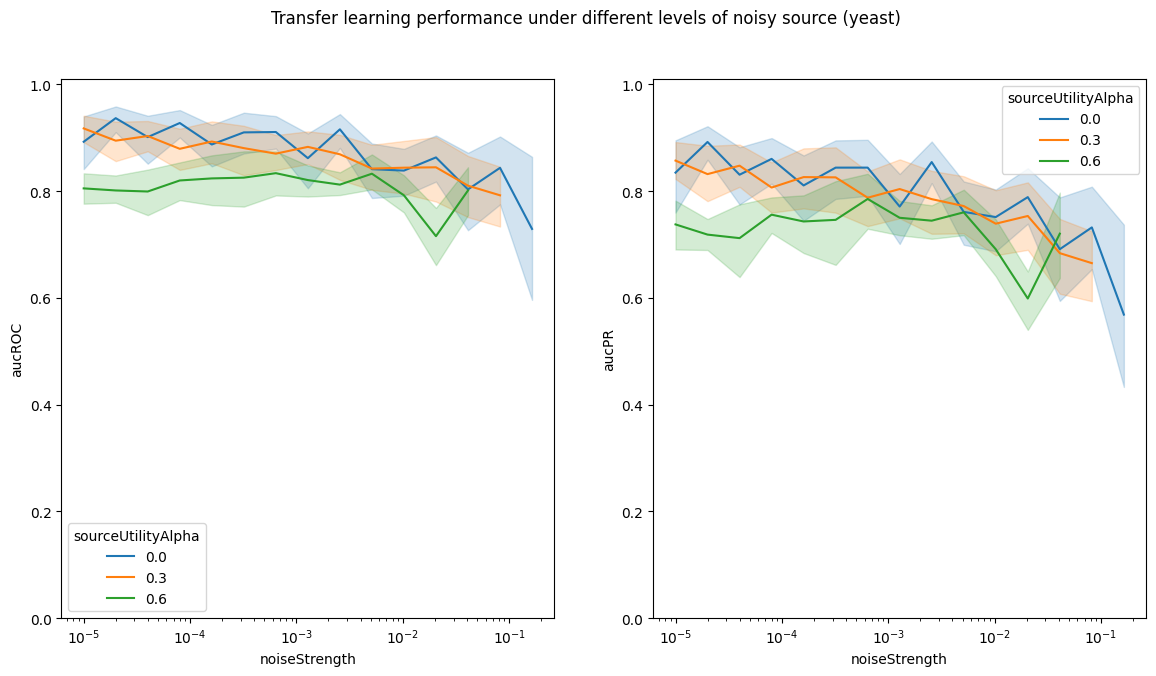

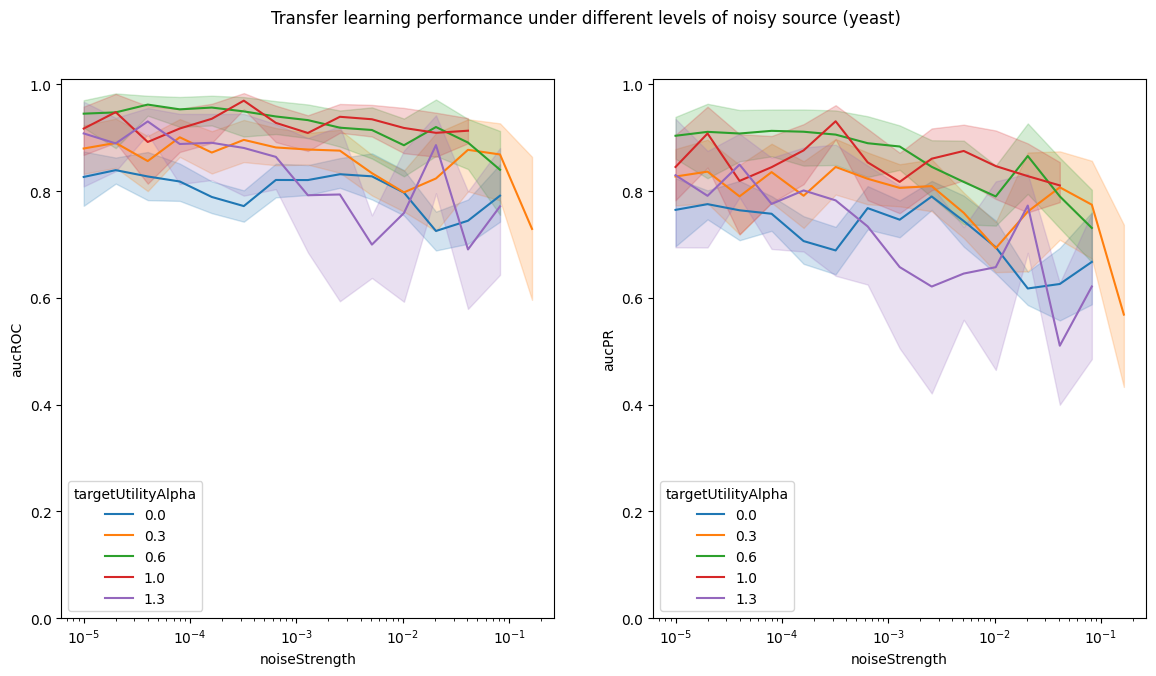

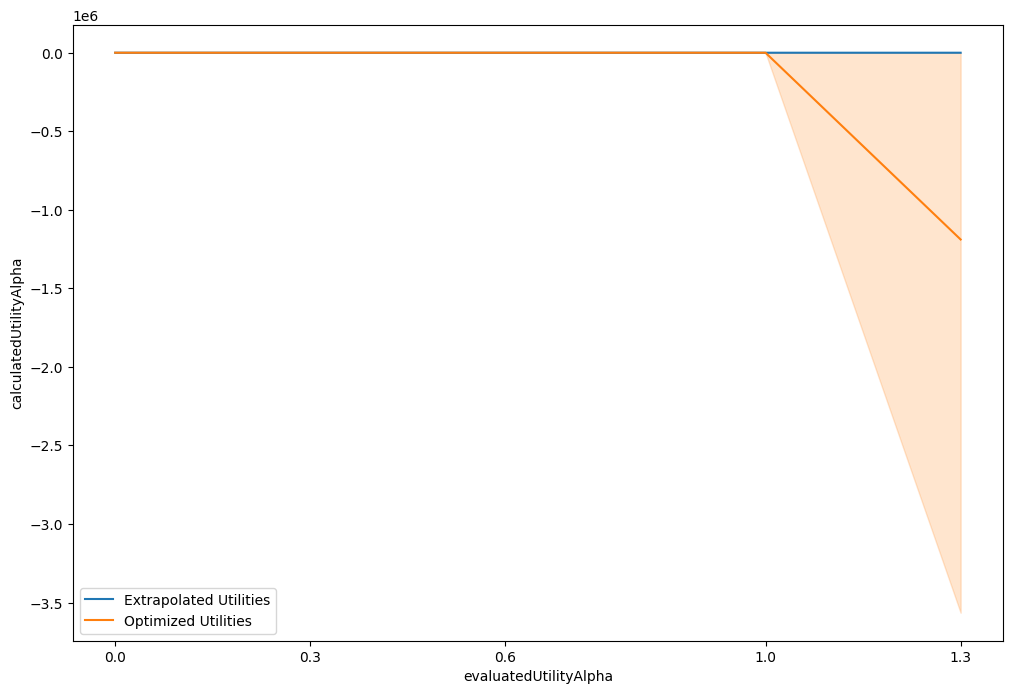

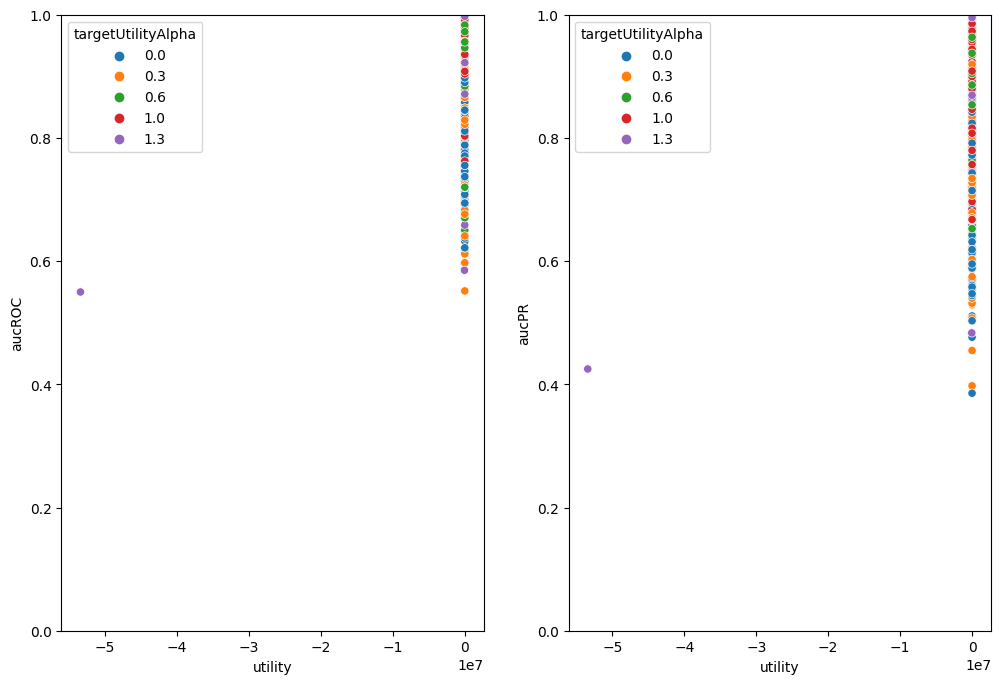

In [59]:
analysisVariables = runAnalysis("yeast")

In [ ]:
plotUtilityVsPredictedProb("b77ccb9efd76ab87dd479d8e3253665713d9d805727d1172dbc9426421bc3892")

Target Utility Alpha: 0.0


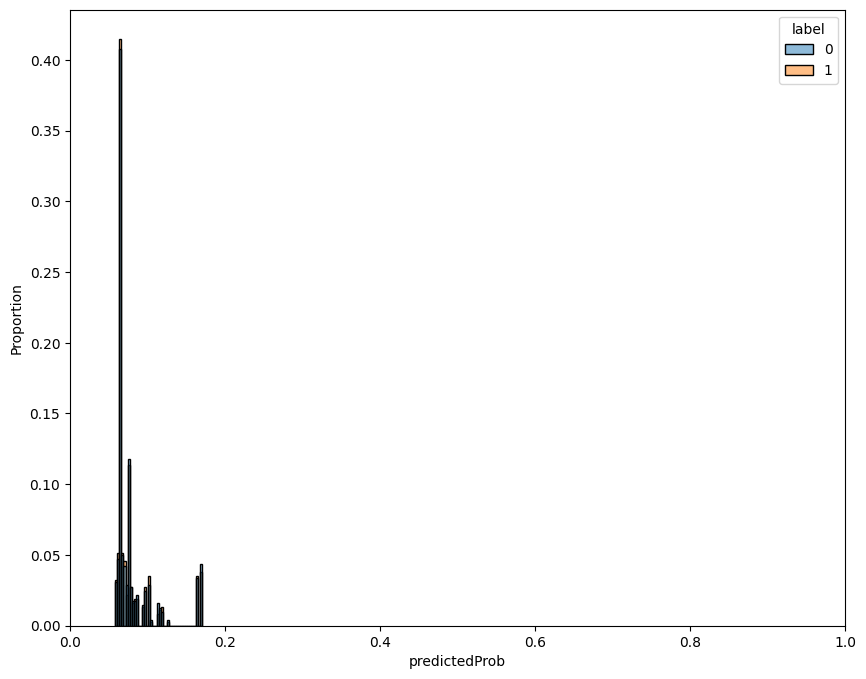

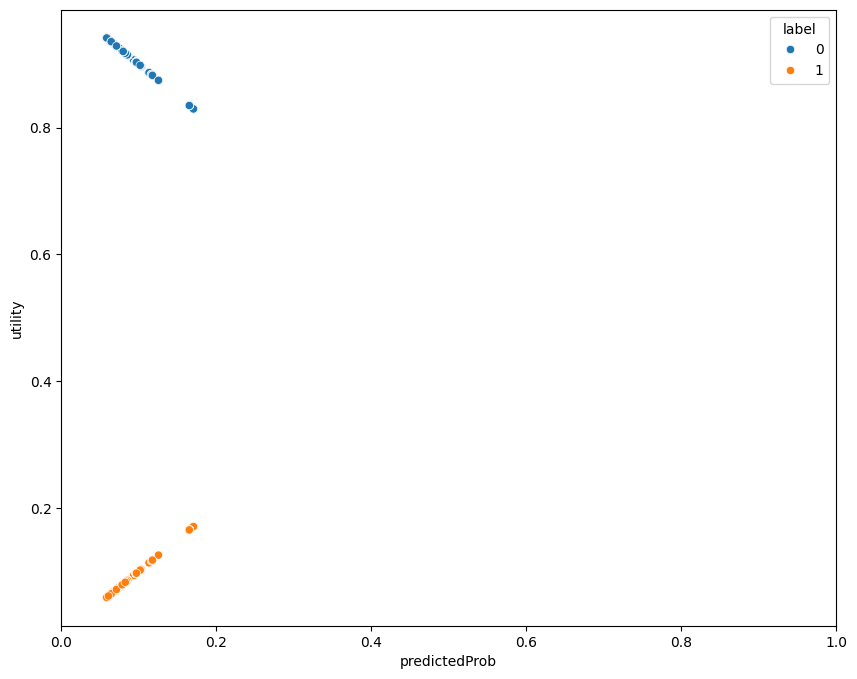

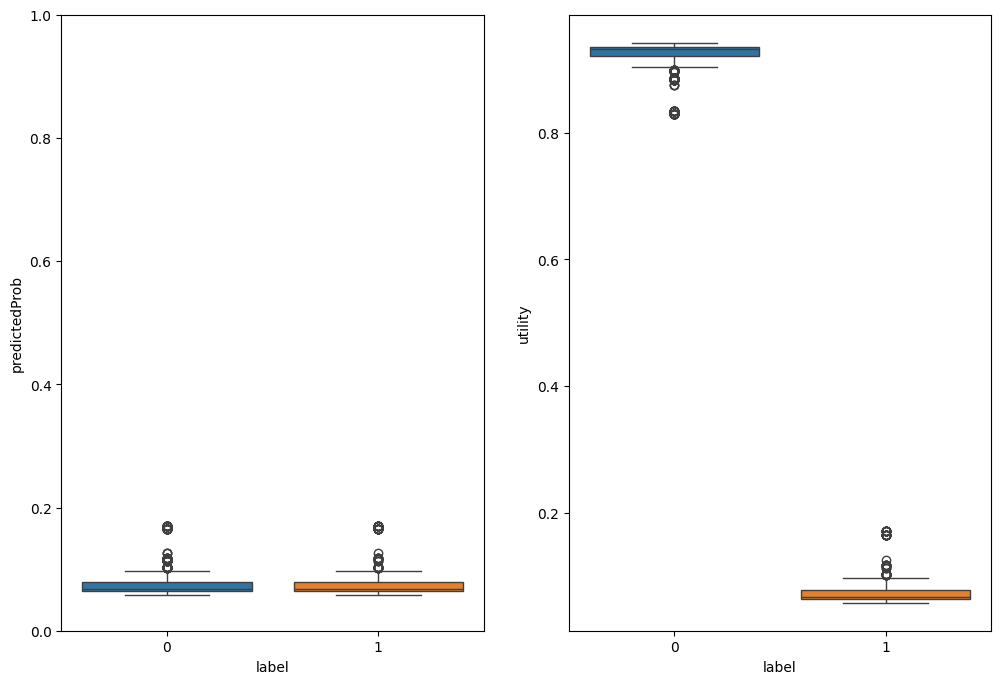

In [ ]:
plotUtilityVsPredictedProb("0d483f3afafda51193c06eb590151f78c6d38fbd50601ea5385e9ef7c2eed6c5")

Pearson Correlation between AUC ROC and Utility at targetUtilityAlpha=0:
(0.7297003114927059, 5.238273685085619e-200)

Pearson Correlation between AUC PR and Utility at targetUtilityAlpha=0:
(0.7939034809899574, 4.1362716265614475e-261)


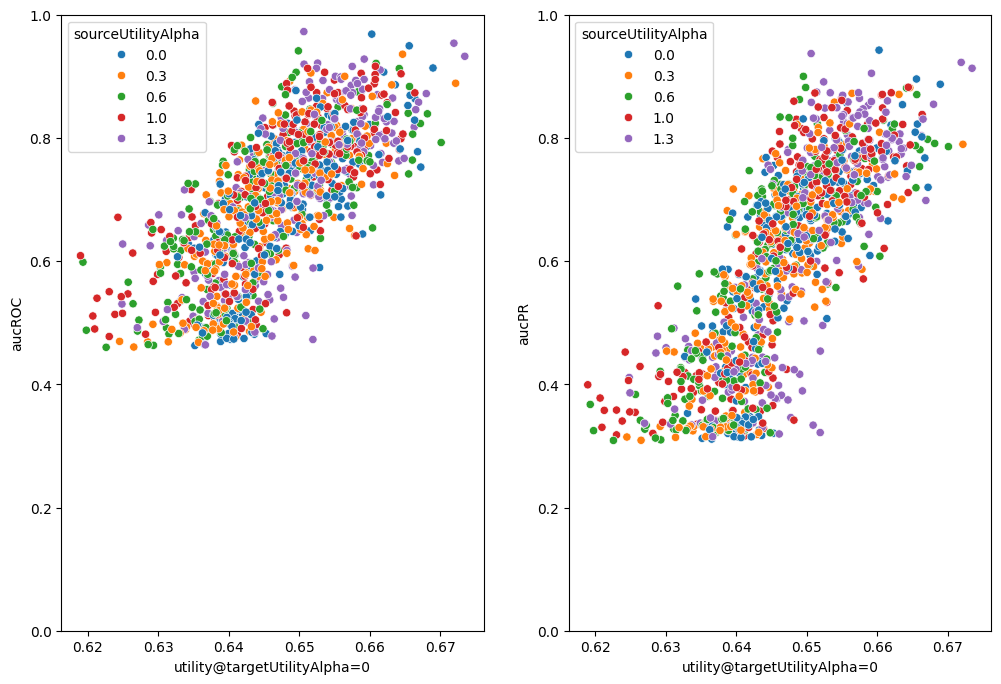

In [ ]:
# Correlation between utility and AUC
database = "yeast"
targetUtilityAlpha = 0
aucUtilityPlotDF = pd.melt(
    utilityAlphaDF.drop(["experimentID"], axis = 1),
    id_vars = ["id", "database", "fold", "targetUtilityAlpha"],
    value_name = f"utility@targetUtilityAlpha={targetUtilityAlpha}",
    var_name = "evaluatedTargetUtilityAlpha"
)

aucUtilityPlotDF = aucUtilityPlotDF[
    (aucUtilityPlotDF.database == database) &
    (aucUtilityPlotDF.targetUtilityAlpha == targetUtilityAlpha)
]
aucUtilityPlotDF = pd.merge(
    aucUtilityPlotDF[
        (aucUtilityPlotDF.database == database)
    ],
    experimentsResultsDF[["id", "sourceUtilityAlpha"]],
    on = "id", 
    how = "left"
)

aucUtilityPlotDF["evaluatedTargetUtilityAlpha"] = aucUtilityPlotDF.evaluatedTargetUtilityAlpha.apply(
    lambda utilityAlpha: float(utilityAlpha.replace("utility@targetAlpha_", ""))
)
aucUtilityPlotDF = aucUtilityPlotDF[aucUtilityPlotDF.targetUtilityAlpha == aucUtilityPlotDF.evaluatedTargetUtilityAlpha]

aucUtilityPlotDF = pd.merge(
    metricsDF.rename(columns = {"experimentID": "id"}),
    aucUtilityPlotDF,
    on = ["id", "fold"],
    how = "inner"
)

aucUtilityPlotDF.head()

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,8))

sns.scatterplot(
    data = aucUtilityPlotDF,
    x = f"utility@targetUtilityAlpha={targetUtilityAlpha}",
    y = "aucROC",
    hue = "sourceUtilityAlpha",
    palette = sns.color_palette(),
    ax = axs[0]
)
axs[0].set_ylim(0,1)

sns.scatterplot(
    data = aucUtilityPlotDF,
    x = f"utility@targetUtilityAlpha={targetUtilityAlpha}",
    y = "aucPR",
    hue = "sourceUtilityAlpha",
    palette = sns.color_palette(),
    ax = axs[1]
)
axs[1].set_ylim(0,1)

correlation_aucROC_utility = pearsonr(aucUtilityPlotDF[f"utility@targetUtilityAlpha={targetUtilityAlpha}"], aucUtilityPlotDF.aucROC)
print(f"Pearson Correlation between AUC ROC and Utility at targetUtilityAlpha={targetUtilityAlpha}:")
print(correlation_aucROC_utility)

print()

correlation_aucPR_utility = pearsonr(aucUtilityPlotDF[f"utility@targetUtilityAlpha={targetUtilityAlpha}"], aucUtilityPlotDF.aucPR)
print(f"Pearson Correlation between AUC PR and Utility at targetUtilityAlpha={targetUtilityAlpha}:")
print(correlation_aucPR_utility)